In [1]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
import pandas_datareader as pdr
from pandas_datareader import data, wb
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [2]:
df=pd.read_csv("NVDAcsvv.csv", decimal = ',')
df.head()

,Date,Open,Close,High,Low,Volume
0,4-Jan-16,32.290001,32.369999,32.580002,32.040001,8951900
1,5-Jan-16,32.98,32.889999,33.439999,32.5,12256800
2,6-Jan-16,32.349998,31.530001,32.5,31.16,11233600
3,7-Jan-16,30.74,30.280001,30.950001,29.879999,16132600
4,8-Jan-16,30.67,29.629999,30.700001,29.57,9961800


In [3]:
# Modelling CAPM and calculating alpha and beta from historical values.
'''
Download monthly prices of NVIDIA and S&P 500 index from 2016 to 2018
CSV file downloaded from Yahoo File
start period: 02/11/2016 
end period: 30/11/2018
period format: DD/MM/YEAR
'''

df_nvda = pdr.get_data_yahoo('NVDA', '2016-01-04', '2018-08-30')

#Collect data on the market from S&P 500 StockPrice data --- GSPC
df_gspc = pdr.get_data_yahoo('^GSPC', '2016-01-04', '2018-08-30')

In [4]:
df_nvda.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,32.580002,32.040001,32.290001,32.369999,8951900.0,31.748003
2016-01-05,33.439999,32.500000,32.980000,32.889999,12256800.0,32.258003
2016-01-06,32.500000,31.160000,32.349998,31.530001,11233600.0,30.924141
2016-01-07,30.950001,29.879999,30.740000,30.280001,16132600.0,29.698162
2016-01-08,30.700001,29.570000,30.670000,29.629999,9961800.0,29.060652


In [5]:
df_gspc.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,2038.199951,1989.680054,2038.199951,2012.660034,4304880000,2012.660034
2016-01-05,2021.939941,2004.170044,2013.780029,2016.709961,3706620000,2016.709961
2016-01-06,2011.709961,1979.050049,2011.709961,1990.260010,4336660000,1990.260010
2016-01-07,1985.319946,1938.829956,1985.319946,1943.089966,5076590000,1943.089966
2016-01-08,1960.400024,1918.459961,1945.969971,1922.030029,4664940000,1922.030029


In [6]:
# joining the closing prices of the two datasets 
monthly_prices = pd.concat([df_nvda['Open'], df_gspc['Open']], axis=1)
monthly_prices.columns = ['NVDA', '^GSPC']

In [7]:
monthly_prices.head()

,NVDA,^GSPC
Date,,
2016-01-04,32.290001,2038.199951
2016-01-05,32.980000,2013.780029
2016-01-06,32.349998,2011.709961
2016-01-07,30.740000,1985.319946
2016-01-08,30.670000,1945.969971


In [8]:
# calculate monthly returns
# Percentage change between the current and a prior element.
#Computes the percentage change from the immediately previous row by default. 
#This is useful in comparing the percentage of change in a time series of elements.

monthly_returns = monthly_prices.pct_change(1)  # 1 used to denote Periods to shift for forming percent change.
clean_monthly_returns = monthly_returns.dropna(axis=0)  # drop first missing row
clean_monthly_returns.head()

,NVDA,^GSPC
Date,,
2016-01-05,0.021369,-0.011981
2016-01-06,-0.019103,-0.001028
2016-01-07,-0.049768,-0.013118
2016-01-08,-0.002277,-0.019820
2016-01-11,-0.032931,-0.010201


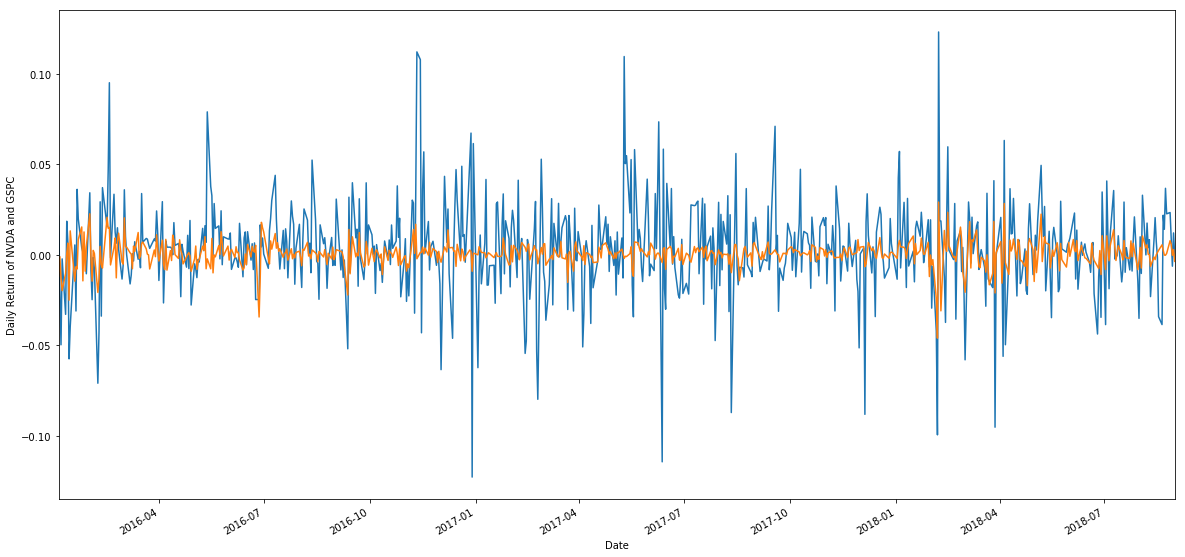

In [9]:
plt.figure(figsize=(20,10))
clean_monthly_returns['NVDA'].plot()
clean_monthly_returns['^GSPC'].plot()
plt.ylabel("Daily Return of NVDA and GSPC")
plt.show()


In [10]:
#Ordinary Least Square (OLS)Regression with Statsmodels.
# split dependent and independent variable
X = clean_monthly_returns['^GSPC']
y = clean_monthly_returns['NVDA']


In [11]:
# Add a constant to the independent value
X1 = sm.add_constant(X)

# make regression model 
model = sm.OLS(y, X1)

# fit model and print results
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     190.9
Date:                Sat, 23 Nov 2019   Prob (F-statistic):           2.24e-38
Time:                        11:28:05   Log-Likelihood:                 1585.5
No. Observations:                 671   AIC:                            -3167.
Df Residuals:                     669   BIC:                            -3158.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.911      0.0

/Users/manalisharma/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The coefficient value for (^GSPC) is 1.6134. If the Beta value provided by Yahoo! Finance is anywhere as close to this figure, then our regression model and attempt to replicate how Yahoo! Finance calculates Beta values is correct.

In [12]:
# alternatively scipy linear regression

#https://finance.yahoo.com/quote/NVDA/

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

print(slope)

1.768894307438861


In [13]:
##model 2

def capm(start_date, end_date, ticker1, ticker2):
    df = pdr.get_data_yahoo(ticker1, start_date, end_date)
    dfb = pdr.get_data_yahoo(ticker2, start_date, end_date)
    df.head()
    dfb.head()
# create a time-series
    rts = df.resample('M').last()
    rbts = dfb.resample('M').last()
    dfsm = pd.DataFrame({'s_open' : rts['Open'], 'b_open' : rbts['Open']}, index=rts.index)

# compute returns
    dfsm[['s_returns', 'b_returns']] = dfsm[['s_open','b_open']]/dfsm[['s_open','b_open']].shift(1) -1
    dfsm = dfsm.dropna()

    covmat = np.cov(dfsm["s_returns"], dfsm["b_returns"])

# calculate measures now
    beta = covmat[0,1]/covmat[1,1]
    alpha = np.mean(dfsm["s_returns"])-beta*np.mean(dfsm["b_returns"])

# r_squared     = 1.0 - SS_res/SS_tot
    y = beta * dfsm["b_returns"] + alpha
    SS_res = np.sum(np.power(y - dfsm["s_returns"],2))
    SS_tot = covmat[0,0]*(len(dfsm) - 1) # SS_tot is sample_variance*(n-1)

    r_squared = 1.0 - SS_res/SS_tot
# Volatility for the full time and 1-year momentum
    volatility = np.sqrt(covmat[0,0])
    momentum = np.prod(1+dfsm["s_returns"].tail(12).values) - 1.0


    prd = 12.0 # used monthly returns; 12 periods to annualize
    alpha = alpha*prd
    volatility = volatility*np.sqrt(prd)

    print ("Beta, alpha, r_squared, volatility, momentum:")
    print (beta, alpha, r_squared, volatility, momentum)

    %pylab
    fig,ax = plt.subplots(1,figsize=(20,10))
    ax.scatter(dfsm["b_returns"], dfsm['s_returns'], label="Data points")
    beta,alpha = np.polyfit(dfsm["b_returns"], dfsm['s_returns'], deg=1)
    ax.plot(dfsm["b_returns"], beta*dfsm["b_returns"] + alpha, color='red', label="CAPM line")


    plt.title('Capital Asset Pricing Model, finding alphas and betas')
    plt.xlabel('Market return $R_m$', fontsize=14)
    plt.ylabel('Stock return $R_i$')
#     plt.text(0.05, 0.05, r'$R_i = \beta * R_m + \alpha$', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()
    return beta, y






In [14]:
beta, y = capm('2016-01-04', '2018-08-30','NVDA', '^GSPC')

Beta, alpha, r_squared, volatility, momentum:
2.166974886131238 0.61859069010838 0.1871663849759383 0.4010004992275091 0.6636636636636639
Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Moving Average Strategy


In [15]:
# Calculating the short-window simple moving average
#calculate the rolling *simple moving averages (SMA)* of these three timeseries as follows. Remember, again, that when calculating the M days SMA, the first M−1 are not valid, as M prices are required for the first moving average data point.

short_rolling = monthly_prices.rolling(window=20).mean()
short_rolling.head(20)

,NVDA,^GSPC
Date,,
2016-01-04,NaN,NaN
2016-01-05,NaN,NaN
2016-01-06,NaN,NaN
2016-01-07,NaN,NaN
2016-01-08,NaN,NaN
2016-01-11,NaN,NaN
2016-01-12,NaN,NaN
2016-01-13,NaN,NaN
2016-01-14,NaN,NaN


In [16]:
# Calculating the long-window simple moving average
long_rolling = monthly_prices.rolling(window=100).mean()
long_rolling.tail()

,NVDA,^GSPC
Date,,
2018-08-27,247.333801,2752.039800
2018-08-28,247.918101,2754.596099
2018-08-29,248.489301,2757.430500
2018-08-30,249.014401,2760.135801
2018-08-31,249.511301,2762.680603


It is straightforward to observe that SMA timeseries are much less noisy than the original price timeseries. However, this comes at a cost: SMA timeseries lag the original price timeseries, which means that changes in the trend are only seen with a delay (lag) of L days.

How much is this lag L? For a SMA moving average calculated using M days, the lag is roughly M2 days. Thus, if we are using a 100 days SMA, this means we may be late by almost 50 days, which can significantly affect our strategy.

One way to reduce the lag induced by the use of the SMA is to use the so-called Exponential Moving Average (EMA), defined as

EMA(t)EMA(t0)=(1−α)EMA(t−1)+α p(t)=p(t0)
where p(t) is the price at time t and α is called the decay parameter for the EMA. α is related to the lag as
α=1L+1
and the length of the window (span) M as
α=2M+1
.

The reason why EMA reduces the lag is that it puts more weight on more recent observations, whereas the SMA weights all observations equally by 1M. Using Pandas, calculating the exponential moving average is easy. We need to provide a lag value, from which the decay parameter α is automatically calculated. To be able to compare with the short-time SMA 

In [17]:
start_date = '2016-01-04'
end_date = '2018-08-30'

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(monthly_prices.loc[start_date:end_date, :].index, monthly_prices.loc[start_date:end_date, 'NVDA'], label='Price')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'NVDA'], label = '100-days SMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'NVDA'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
#ax.xaxis.set_major_formatter(my_year_month_fmt)

Text(0, 0.5, 'Price in $')

Text(0, 0.5, 'Price in $')

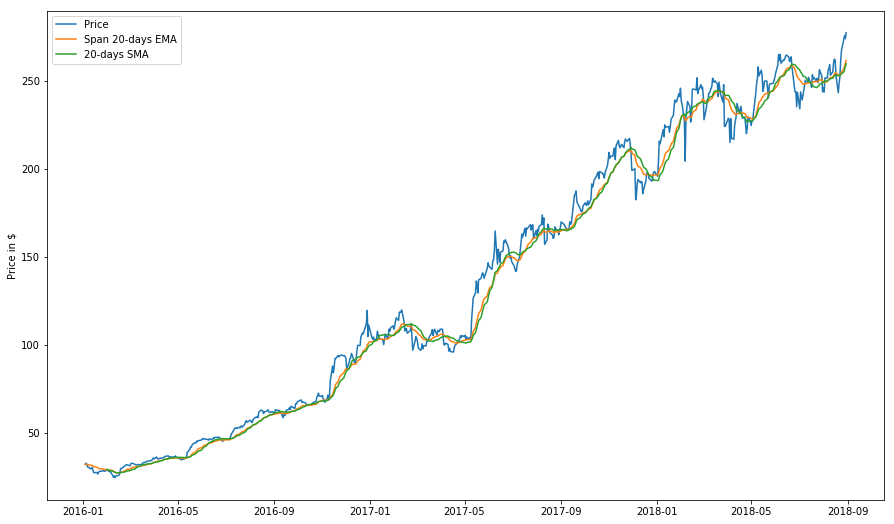

In [20]:
ema_short = monthly_prices.ewm(span=20, adjust=False).mean()

fig, ax = plt.subplots(figsize=(15,9))

ax.plot(monthly_prices.loc[start_date:end_date, :].index, monthly_prices.loc[start_date:end_date, 'NVDA'], label='Price')
ax.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'NVDA'], label = 'Span 20-days EMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'NVDA'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')


t is natural to assume that when a change in the long term behaviour of the asset occurs, the actual price timeseries will react faster than the EMA one. Therefore, we will consider the crossing of the two as potential trading signals.

When the price timeseries p(t) crosses the EMA timeseries e(t) from below, we will close any existing short position and go long (buy) one unit of the asset.
When the price timeseries p(t) crosses the EMA timeseries e(t) from above, we will close any existing long position and go short (sell) one unit of the asset.

In [23]:
## Taking the difference between the prices and the EMA timeseries
trading_positions_raw = monthly_prices - ema_short
trading_positions_raw.tail()

,NVDA,^GSPC
Date,,
2018-08-27,16.787623,41.078083
2018-08-28,17.215459,52.329703
2018-08-29,14.001615,46.595119
2018-08-30,15.662887,49.684949
2018-08-31,13.963079,35.389875


How is this translated to the framework described in our previous article about the weights w(t)?

Well for this strategy it is pretty straghtforward. All we need is to have a long position, i.e. wi(t) >0, as long as the price timeseries is above the EMA timeseries and a short position, i.e. wi(t) < 0, as long as the price timeseries is below the EMA timeseries.

Since, at this point, we are not interested yet in position sizing, we will assume that we use all our funds available to trade asset i. We will also assume that our funds are split equally across all 3 assets (NVDA and ^GSPC).

Based on these assumptions, our strategy for each of the assets i,i=1,…,2 can be translated as follows:

Go long condition: If pi(t)>ei(t), then wi(t)=1/2
Go short condition: If pi(t)<ei(t), then wi(t)=−1/2
Whenever, the trade conditions are satisfied, the weights are 1/2 because 1/2 of the total funds are assigned to each asset and whenever we are long or short, all of the available funds are invested.

How is this implemented in Python? The trick is to take the sign of the difference between then price pi(t) and the EMA ei(t).

In [25]:
# Taking the sign of the difference to determine whether the price or the EMA is greater and then multiplying by 1/3
trading_positions = trading_positions_raw.apply(np.sign) * 1/2
trading_positions.tail()

,NVDA,^GSPC
Date,,
2018-08-27,0.5,0.5
2018-08-28,0.5,0.5
2018-08-29,0.5,0.5
2018-08-30,0.5,0.5
2018-08-31,0.5,0.5


One Final Caveat
Before seeing the performance of this strategy, let us focus on the first day to when the price timeseries p(to) crosses above and EMA timeseries ei(to). Since p(to)>ei(to). At that point the trading weight wi(to) becomes positive, and thus according to our trading strategy, we need to set for that day wi(to)=13.

However, bear in mind that p(to) is the price of the asset at the close of day to. For this reason, we will not know that p(to)>ei(to) until the close of the trading day. Therefore, when calculating the returns of the strategy, to assume that on day to we had a long position is an error; it is equivalent to us peaking into the future, since we only know we have to go long at the end of day to.

The best we can do is assume that we traded at the close of this day to. Therefore our position will be long starting on the following day, to+1. This is easily corrected for by lagging our trading positions by one day, so that on day to our actual position is that of the previous day to−1 and only on day to+1 do we have a long position. Thus:

In [26]:
# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)

Text(0, 0.5, 'Trading position')

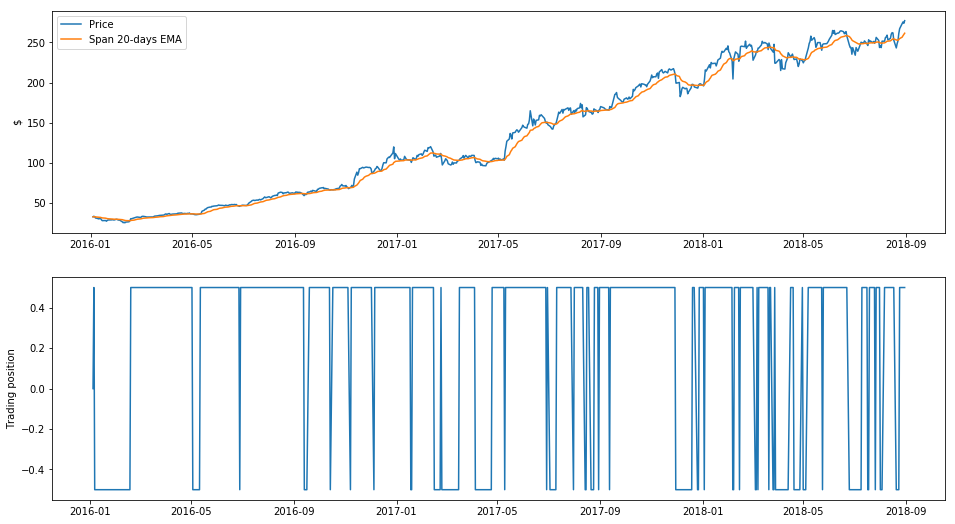

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

ax1.plot(monthly_prices.loc[start_date:end_date, :].index, monthly_prices.loc[start_date:end_date, 'NVDA'], label='Price')
ax1.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'NVDA'], label = 'Span 20-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')
#ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date, 'NVDA'], 
        label='Trading position')

ax2.set_ylabel('Trading position')


Now that the position our strategy dictates each day has been calculated, the performance of this strategy can be easily estimated. To that end, we will need again the log-returns of the three assets ri(t). These are calculated as:

In [29]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
asset_log_returns = np.log(monthly_prices).diff()
asset_log_returns.head()

,NVDA,^GSPC
Date,,
2016-01-04,NaN,NaN
2016-01-05,0.021144,-0.012053
2016-01-06,-0.019287,-0.001028
2016-01-07,-0.051049,-0.013205
2016-01-08,-0.002280,-0.020020


In [33]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
strategy_asset_log_returns = trading_positions_final * asset_log_returns
strategy_asset_log_returns.tail()

,NVDA,^GSPC
Date,,
2018-08-27,0.011543,0.003887
2018-08-28,0.004080,0.002897
2018-08-29,-0.003166,-0.000143
2018-08-30,0.006006,0.001432
2018-08-31,-0.000415,-0.001820


##Remembering that the log-returns can be added to show performance across time, let us plot the cumulative log-returns and the cumulative total relative returns of our strategy for each of the assets


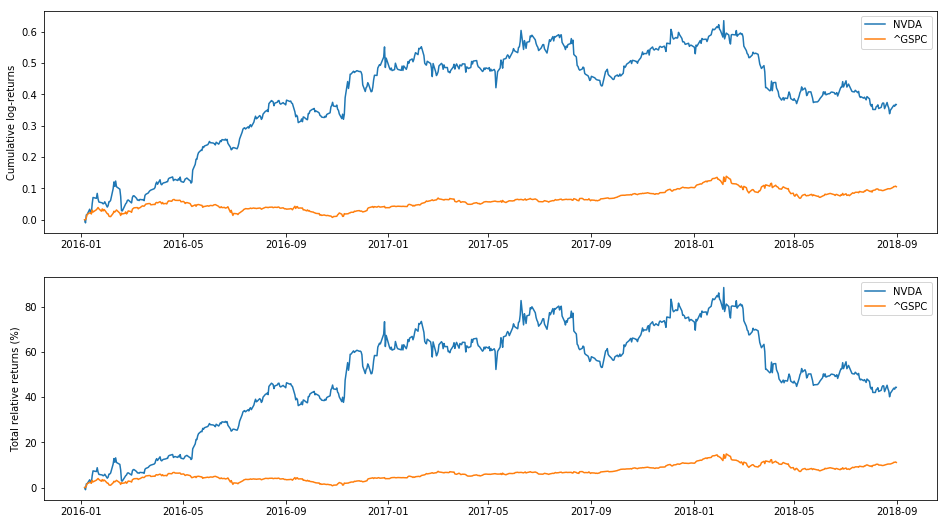

In [34]:
# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns:
    ax1.plot(cum_strategy_asset_log_returns.index, cum_strategy_asset_log_returns[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
#ax1.xaxis.set_major_formatter(my_year_month_fmt)

for c in asset_log_returns:
    ax2.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns[c], label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')

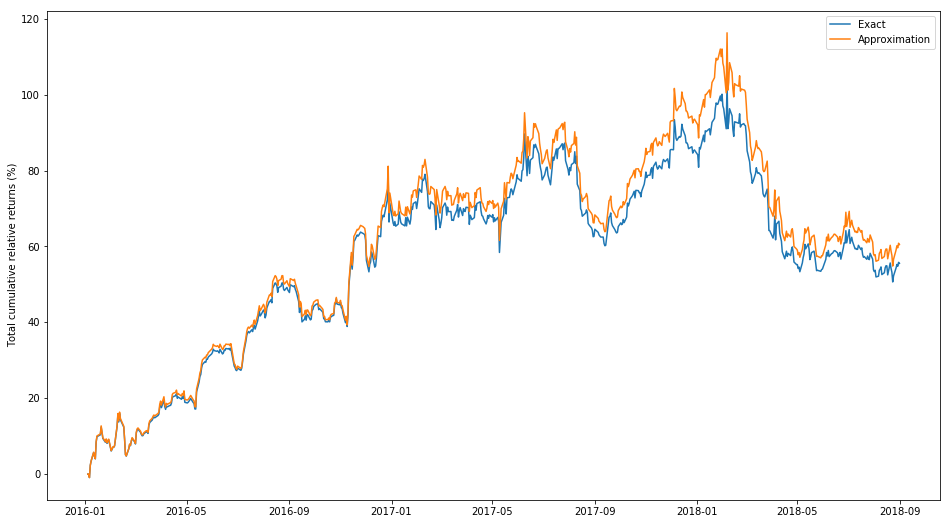

In [36]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_asset_relative_returns.sum(axis=1)

# Get the cumulative log-returns per asset
cum_strategy_log_return = cum_strategy_asset_log_returns.sum(axis=1)

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='Exact')
ax.plot(cum_relative_return_approx.index, 100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
#ax.xaxis.set_major_formatter(my_year_month_fmt)

As we can see, for relatively small time-intervals and as long the assumption that relative returns are small enough, the calculation of the total strategy returns using the log-return approximation can be satisfactory. However, when the small scale assumption breaks down, then the approximation is poor. Therefore what we need to remember the following:

Log-returns can and should be added across time for a single asset to calculate cumulative return timeseries across time.
However, when summing (or averaging) log-returns across assets, care should be taken. Relative returns can be added, but log-returns only if we can safely assume they are a good-enough approximation of the relative returns.